In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Introduction
### 📌 Notebook goal

> implement a vision transfomer model and fine tuning on our dataset to classify  3 type of tumor

### ⓘ Dataset Description :

> The combination of two datasets BR35H and Figshare with a random selection of about 600 images from them with slight changes in the angles of the photos with the help of rotation to prevent overfitting.
  

# Table of Contents:
  * [Imports](#section1)
  * [Reading Data And Preparing](#section2)
    * [Read And Show Data]
    * [Preapare Data]  
  * [Explore and Visualization of MRI brain tumor images  ](#section3)
  * [Build and fine-tunne ViT (Vision Transformers) for tumor classification](#section4)
  * [Models Evaluation](#section5)
  * [Conclusion](#section6)
        

# Imports  <a class="anchor" id="section1"></a>

In [ ]:
!pip install tensorflow-addons vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
#import some necessary librairies
import os
import os.path
from pathlib import Path
import glob
import warnings
import shutil
import itertools
from warnings import filterwarnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore all warning  message from librairies

# linear algebra
import numpy as np
# data processing
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

#machine learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

from vit_keras import vit, utils, visualize

import cv2
from PIL import Image

#metrics for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,classification_report




### setup configs

In [ ]:
%matplotlib inline
sns.set_theme()

In [ ]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# CONSTANTS

In [ ]:
PROJECT_NAME = "" #just for project title
RANDOM_SEED = 42
IMAGE_SIZE = (224,224)
image_size =IMAGE_SIZE[0]
SAMPLE_NUMBER = 1
VAL_SPLIT_SIZE  = 0.1
# Dataset part used for testing
TEST_SPLIT_SIZE = 0.2
# Batch size for training
BATCH_SIZE = 16
# Training Epochs
EPOCHS = 100
# Filters for pretrained models
#FILTER_LIST = [ 32,64,128 ]

In [ ]:
MAIN_PROJECT_PATH=  "/content/drive/MyDrive/projects/my_final_project/01_classification_vit_model"
VIT_DATASET_PATH  = "/content/drive/MyDrive/projects/my_final_project/datasets/vit_dataset"

#we use yolo dataset to prepare image dataset for vit
YOLO_DATASET_TRAIN = "/content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train"
YOLO_DATASET_TEST = "/content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/test"

# Reading Data And Preparing  <a class="anchor" id="section2"></a>

In [ ]:

def extract_images_from_yolo_dataset(dataset_folder, output_folder):
    # iterate through the dataset folder
    for root, dirs, files in os.walk(os.path.join(dataset_folder, "labels")):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), 'r') as label_file:
                    lines = label_file.readlines()
                    for line in lines:
                        # Extract class and bounding box coordinates
                        class_label, x_center, y_center, width, height = map(float, line.split()[0:5])

                        # Read the corresponding image
                        image_path = os.path.join(dataset_folder, "images", os.path.splitext(file)[0] + ".jpg")
                        image = cv2.imread(image_path)


                        #x1 = int((x_center - width/2) * image.shape[1])
                        #y1 = int((y_center - height/2) * image.shape[0])
                        #x2 = int((x_center + width/2) * image.shape[1])
                        #y2 = int((y_center + height/2) * image.shape[0])
                        #object_image = image[y1:y2, x1:x2]

                        # Save the object image to the output folder
                        output_class_folder = os.path.join(output_folder, str(int(class_label)))
                        os.makedirs(output_class_folder, exist_ok=True)
                        output_image_path = os.path.join(output_class_folder, f"{os.path.splitext(file)[0]}_{int(class_label)}.jpg")
                        cv2.imwrite(output_image_path,  image)


extract_images_from_yolo_dataset(YOLO_DATASET_TRAIN,
                                VIT_DATASET_PATH+"/train")
extract_images_from_yolo_dataset(YOLO_DATASET_TEST,
                                VIT_DATASET_PATH+"/test")


In [ ]:
def read_and_load_images(dir_path ):
    X = []
    y = []
    for root, dirs, files in os.walk(dir_path):
        for d in dirs:
          images_dir_path = os.path.join(root,d)
          images = glob.glob(images_dir_path+os.sep+"*.jpg")
          for img in images :
            img_file = cv2.imread(img)
            img_file = cv2.resize(img_file,(224,224))
            X.append(img_file)
            y.append(int(d))

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

In [ ]:
DIR= VIT_DATASET_PATH
TRAIN_DIR = f'{DIR}/train'
TEST_DIR =  f'{DIR}/test'

X_train, y_train = read_and_load_images(TRAIN_DIR )
X_test, y_test= read_and_load_images(TEST_DIR )

2810 images loaded from /content/drive/MyDrive/projects/my_final_project/datasets/vit_dataset/train directory.
50 images loaded from /content/drive/MyDrive/projects/my_final_project/datasets/vit_dataset/test directory.


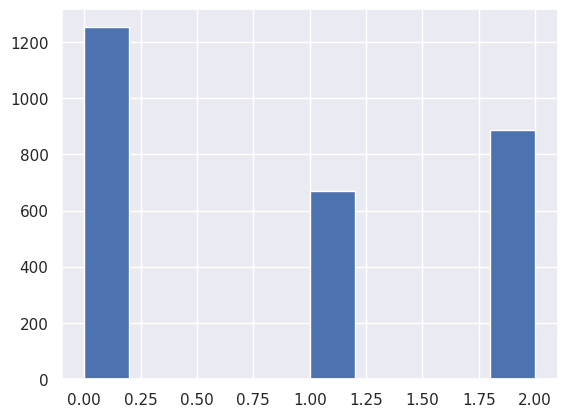

In [ ]:
plt.hist(y_train);

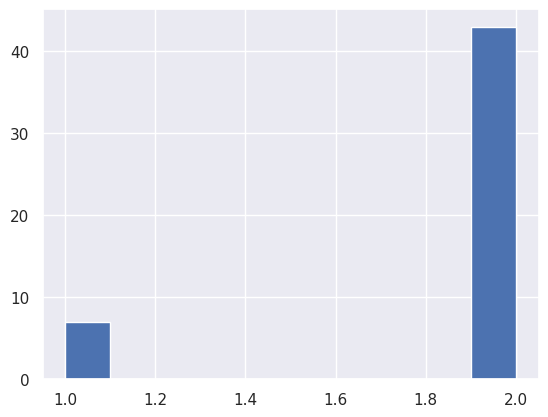

In [ ]:
plt.hist(y_test);

# Explore and Visualization of MRI brain tumor images   <a class="anchor" id="section3"></a>

In [ ]:
sample_number_index = np.where(y_train==0)[0][SAMPLE_NUMBER]
sample_number_index

888

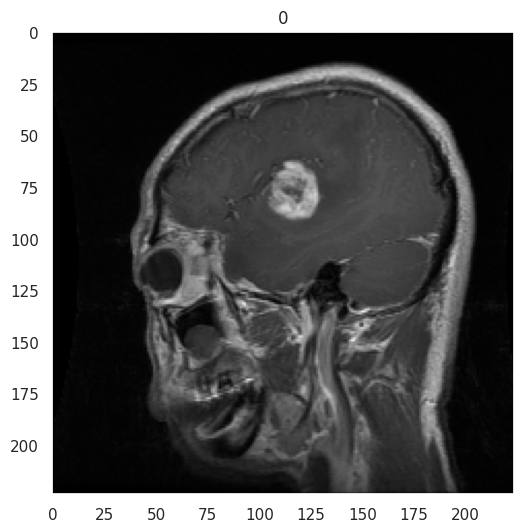

In [ ]:
#plot and see a sample MRI image that has tumor ( label = 0)
figure = plt.figure(figsize=(6,6))
plt.imshow(X_train[sample_number_index])
plt.title(y_train[sample_number_index]);
plt.grid(False)

In [ ]:
class_names = {0:'glioma-tumor',  1:'meningioma-tumor', 2:'pituitary-tumor'}

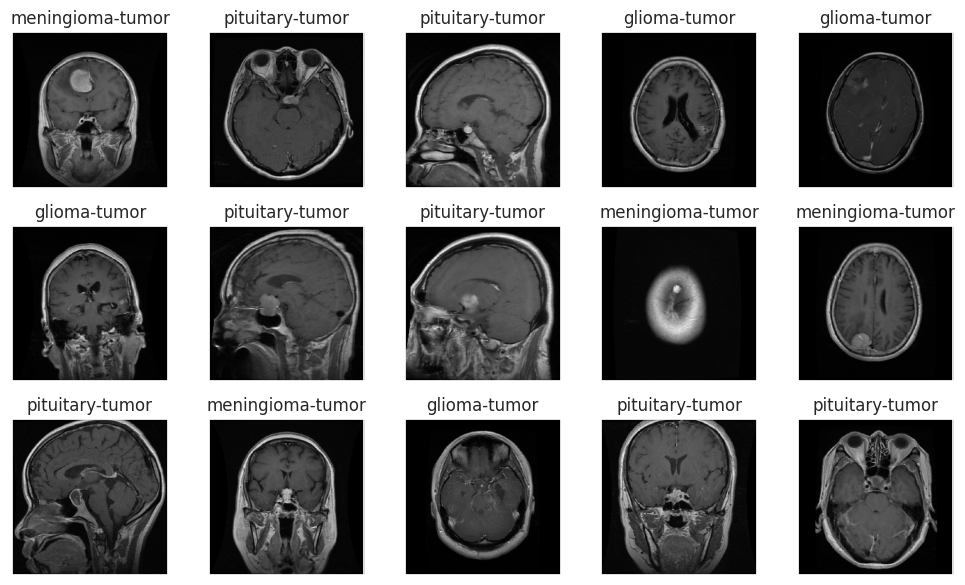

In [ ]:
fig, axes = plt.subplots(nrows=3,
                         ncols=5,
                         figsize=(10, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat ):
    index= random.randint(0,len(X_train))
    ax.imshow(X_train[index])
    ax.set_title(class_names[y_train[index]] )
plt.tight_layout()

### Split dataset into Train/Test for training and evaluation

In [ ]:
#first split the train / test
X_train,X_test ,y_train,y_test = train_test_split(X_train,y_train,shuffle=True,test_size=TEST_SPLIT_SIZE,random_state=42)
#then split train data into train and validation
#X_train,X_valid ,y_train,y_valid = train_test_split(X_train,y_train,shuffle=True,test_size=VAL_SPLIT_SIZE,random_state=42)

In [18]:
# how many data we have in our train and test and validation sets (and their shapes)
print(f" TRAIN DATA SHAPE : {X_train.shape}")
print(f" TEST DATA SHAPE : {X_test.shape}")
#print(f" VALIDATION DATA SHAPE : {X_valid.shape}")

 TRAIN DATA SHAPE : (2248, 224, 224, 3)
 TEST DATA SHAPE : (562, 224, 224, 3)


# FIRST Model  : ViT (Vision Transformers)

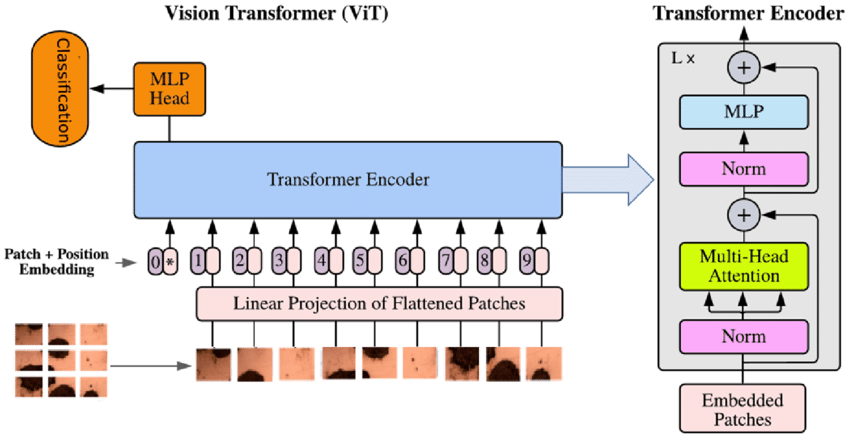

### Visualizing Attention Maps of Sample Test Image¶


In [19]:

class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


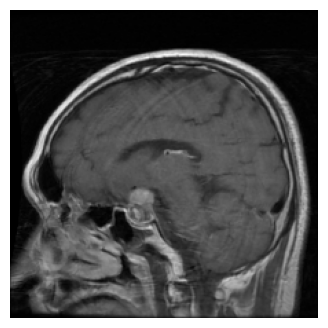

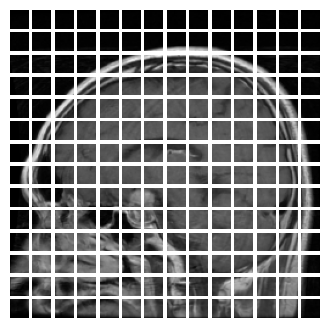

In [20]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

#x = train_gen.next()
image = X_train[119]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')



### Sample Visualizing Attention Maps


In [21]:
image_size = 224
vitmodel = vit.vit_b16(
    image_size=image_size,
    classes=3,
    pretrained=True,
    include_top=True,
    pretrained_top=False
)

347502902/347502902 [==============================] - 5s 0us/step


1/1 [==============================] - 6s 6s/step


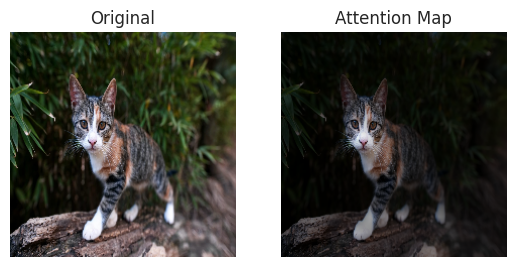

In [22]:
url = 'https://cdn.vpets.com.au/wp-content/uploads/2021/05/29075351/vpets-ecological-damage-of-cats-1536x1026.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=vitmodel, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

Sample Visualizing Attention Maps on Our Data

1/1 [==============================] - 5s 5s/step


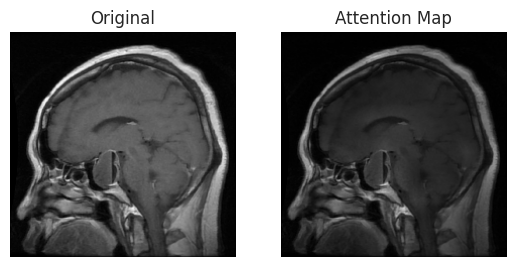

In [23]:
image = X_train[90]
attention_map = visualize.attention_map(model=vitmodel, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [24]:
import gc
gc.collect()

23584

In [25]:
XX_train = vit.preprocess_inputs(X_train).reshape(len(X_train), image_size, image_size, 3)

In [26]:
XX_test = vit.preprocess_inputs(X_test).reshape(len(X_test), image_size, image_size, 3)

In [27]:
num_classes = 3
num_classes

3

In [28]:
y_train_vit = keras.utils.to_categorical(y_train, num_classes)
y_test_vit = keras.utils.to_categorical(y_test, num_classes)

###  Fine-tuning a pretrained ViT on  tumor data

In [29]:
# Load a pretrained ViT model
image_size = 224
model = vit.vit_b16(
    image_size=image_size,
    activation="softmax",
    classes=num_classes,
    pretrained=True,
    include_top=True,
    pretrained_top=False, )

In [30]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2]), array([997, 546, 705]))

In [ ]:
# Train the model
epochs = 20
batch_size = 8
csv_logger = keras.callbacks.CSVLogger(MAIN_PROJECT_PATH+os.sep+'training.log')
history=model.fit(XX_train, y_train_vit, batch_size=batch_size, epochs=epochs,shuffle=False, validation_split=0.2,callbacks=[csv_logger])

Epoch 1/20
175/225 [======================>.......] - ETA: 18:18 - loss: 0.3777 - accuracy: 0.8529

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save(MAIN_PROJECT_PATH+os.sep+"vit_model_trained.h5")

### Visualizing Attention on Brain Tumor After Fine Tuning  model

In [ ]:
image = X_train[330]
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [ ]:
image = X_train[180]
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [ ]:
y_hat = model.predict(XX_test)
y_pred = np.argmax(y_hat, axis=1)

### Trained Model ViT Evaluation

In [ ]:
model.evaluate(XX_test,y_test_vit)

In [ ]:
# Evaluate the model on Test Data
test_loss, test_accuracy = model.evaluate(XX_test, y_test_vit)
print(f"Test accuracy: {test_accuracy}")

In [ ]:
#Confution Matrix and Classification Report
YY_pred = model.predict(XX_test)
Y_pred = np.argmax(YY_pred, axis=1)
cm =confusion_matrix(y_test, y_pred)
print('Classification Report')
target_names = [ 'glioma-tumor',  'meningioma_tumor', 'pituitary_tumor']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
import pandas as pd
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_df

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=  target_names )
display.plot()
plt.grid(False)

<img source="https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FVision-Transformer-ViT-model-architecture-ViT-breaks-the-image-into-patches-and-treats_fig2_362567384&psig=AOvVaw3lynLWpC2LDj6Hq2vQJLmU&ust=1693583439393000&source=images&cd=vfe&opi=89978449&ved=0CBAQjRxqFwoTCLD4142gh4EDFQAAAAAdAAAAABAh" />